Copyright 2021 M.A. van den Berg, thijs@sitmo.com

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Denoising Covariance Matrices for Portfolio Optimisation

This notebook demonstrated how to use denoising techniques on empirical covariance matrices in order to make better portfolio allocations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
np.set_printoptions(precision=4)

# Part 1: simulating returns

## Start with a "true" correlation matrix

First we make a fake correlation matrix. This is supposed to be the "true" unobserved correlation matrix. It has blocks of mutually correlated series, think of those as being sectors of correlated assets. 

In [2]:
def block_diagonal_cor(block_sizes=[10, 10, 20, 24, 64], block_cors=[0.5, 0.2, 0.3, 0.5, 0.3]):
    N = np.sum(block_sizes)
    cor = np.zeros((N, N))
    i = 0
    for block_size, block_cor in zip(block_sizes, block_cors):
        cor[i:i + block_size, i:i + block_size] = block_cor
        i += block_size
    np.fill_diagonal(cor, 1.0)
    return cor

In [3]:
true_cor = block_diagonal_cor()

num_assets = true_cor.shape[0]

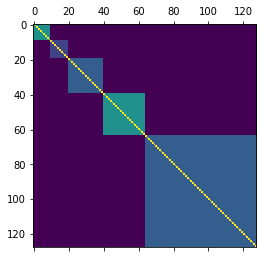

In [4]:
plt.matshow(true_cor)
plt.show()

## Create a covariance matrix from the correlation matrix

Scale up the asset vollatility with a random factors for each asset to create a covariance matrix out of the correlation matrix.

In [5]:
def cov_to_cor(cov, cov_reg=1E-6):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.maximum(np.diag(cov), cov_reg))

    cor = cov / np.outer(std, std)
    cor[cor < -1.0], cor[cor > 1.0] = -1.0, 1.0
    return cor, std


def cor_to_cov(cor, std):
    cov = cor * np.outer(std, std)
    return cov

In [6]:
true_std = np.random.uniform(0.1, size=num_assets)

true_cov = cor_to_cov(true_cor, true_std)

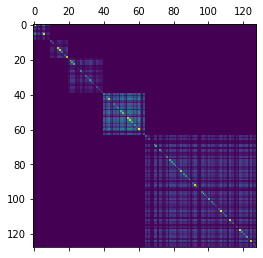

In [7]:
plt.matshow(true_cov)
plt.show()

## Create random asset return time series

Now we create simulated asset prices, using the "true covariance matrix" in our simulator. These time-series will be our starting point of our analysis.

Using these time-series we will try to recover the true covariance matrix. We won't be able to do this perfectly because the simulated timeseries have limited lengths, and this creates uncertaintly and noise in the estimated covariances.

In [8]:
num_timesteps = 252

observed_returns = np.random.multivariate_normal(mean=np.zeros(num_assets), cov=true_cov, size=num_timesteps)

### To give an idea, plot the first three asset returns

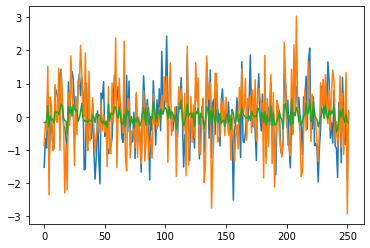

In [9]:
plt.plot(observed_returns[:,:3])
plt.show()

### Another view: Scatterplot of the first two assets, showing the correlation

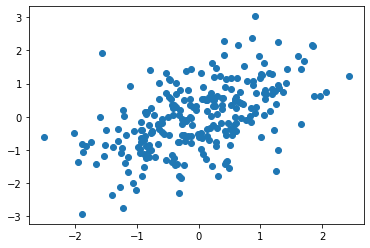

In [10]:
plt.scatter(observed_returns[:,0], observed_returns[:,1])
plt.show()

# Part 2: estimate the covariance from asset return time series

Here we'll estimate the covariance matrix base on the available time series data. It will deviate from the true covariance matrix because we estimated the covariances using finite length observed return time series. 

In [11]:
observed_cov = np.cov(observed_returns.T)
observed_cor, observed_std = cov_to_cor(observed_cov)

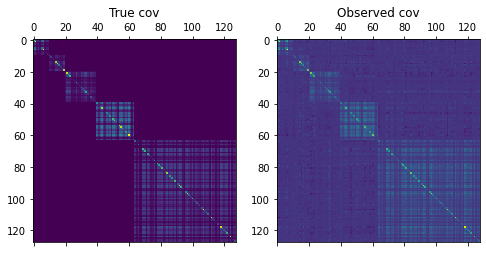

In [12]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
ax0.matshow(true_cov)
ax1.matshow(observed_cov)
ax0.set_title('True cov')
ax1.set_title('Observed cov')
plt.show()

## Why is noise a problem?
In many asset management applications like computing the "minimum variance allocation" or "maximum Sharpe ratio allocation" we need to compute the inverse of this covariance matrix (called the "precision matrix"). 

During the matrix inversion, the noise in the covariance values get's amplified causing the computed asset weights to be noisy, and hence the minimum variance allocation to be sub-optimal.

How much the noise gets amplified depends on the "condition number" of the covariance matrix. The condition number is simple the ratio of the largest eigenvalue divided by the smallest eigenvalue. 

Below is an example of inverting a matrix and how the condition number links to stability of that inverse matrix.

In [13]:
def eig_to_cor(eigen_values, eigen_vectors):
    cor = np.dot(eigen_vectors, eigen_values[:, np.newaxis] * eigen_vectors.T)
    # fix numerical issues
    cor[cor < -1] = -1
    cor[cor > 1] = 1
    np.fill_diagonal(cor, 1.0)
    return cor

def cor_to_eig(cor, sort=True, real=True):
    eigen_values, eigen_vectors = np.linalg.eigh(cor)
    if sort:
        idx = eigen_values.argsort()[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
    if real:
        eigen_vectors = eigen_vectors.real
        eigen_values = eigen_values.real
    return eigen_values, eigen_vectors

In [14]:
good_matrix = np.array([[2.0,-1.0],[-1.0,2.0]])
print('good_matrix\n', good_matrix)

eig_vals, _ = cor_to_eig(good_matrix)
print(f'\nCondition number of good_matrix {eig_vals[0]/eig_vals[1]:.2f}')

print('\ninverse of good matrix\n',np.linalg.inv(good_matrix))

good_matrix[0,1] -= 0.01
good_matrix[1,0] -= 0.01

print('\nsmall change to good_matrix\n', good_matrix)

print('\ninverse of the slightly changed good matrix doesn\'t change much\n',np.linalg.inv(good_matrix))

good_matrix
 [[ 2. -1.]
 [-1.  2.]]

Condition number of good_matrix 3.00

inverse of good matrix
 [[0.6667 0.3333]
 [0.3333 0.6667]]

small change to good_matrix
 [[ 2.   -1.01]
 [-1.01  2.  ]]

inverse of the slightly changed good matrix doesn't change much
 [[0.6712 0.3389]
 [0.3389 0.6712]]


In terms of portfolio management this means that small change is the observed correlations between assets will result in small changes in the optimal portfolio weights.

The next example is a bad conditioned matrix. This matrix has a large condition number, and small changes in the matrix will now result in big changes in the inverse of the matrix.

In [15]:
bad_matrix = np.array([[1.011,-1.0],[-1.0,1.011]])
print('bad_matrix\n', bad_matrix)

eig_vals, _ = cor_to_eig(bad_matrix)
print(f'\nCondition number of bad_matrix {eig_vals[0]/eig_vals[1]:.4f}')


print('\ninverse of bad matrix\n',np.linalg.inv(bad_matrix))

bad_matrix[0,1] -= 0.01
bad_matrix[1,0] -= 0.01

print('\nsmall change to bad_matrix\n', bad_matrix)

print('\ninverse of the slightly changed bad matrix looks completely different\n',np.linalg.inv(bad_matrix))

bad_matrix
 [[ 1.011 -1.   ]
 [-1.     1.011]]

Condition number of bad_matrix 182.8182

inverse of bad matrix
 [[45.7032 45.2059]
 [45.2059 45.7032]]

small change to bad_matrix
 [[ 1.011 -1.01 ]
 [-1.01   1.011]]

inverse of the slightly changed bad matrix looks completely different
 [[500.2474 499.7526]
 [499.7526 500.2474]]


## Improving the condition number and making the matrix inverse more stable

Below you see the sorted eigenvalues of the true correlation matrix we started out with, and the observer correlation matrix that we computed from the simulated asset timeseries. The condition number with be the ratio of the largest vs the smallest eigenvalue.

In [16]:
true_eigen_values, true_eigen_vectors = cor_to_eig(true_cor)
obs_eigen_values, obs_eigen_vectors = cor_to_eig(observed_cor)

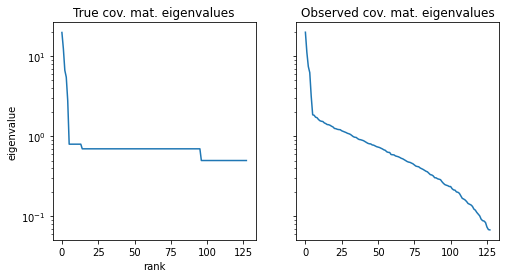

In [17]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax0.semilogy(true_eigen_values)
ax1.semilogy(obs_eigen_values)
ax0.set_title('True cov. mat. eigenvalues')
ax1.set_title('Observed cov. mat. eigenvalues')
ax0.set_xlabel('rank')
ax0.set_ylabel('eigenvalue')
plt.show()

You can clearly see that the largest eigenvalue is the same for the two matrices, but the smallest eigenvalue is much smaller in the right plot. As a consequence the right matrix will have a much larger condition number and have instabilties when computing the inverse.

In [18]:
print(f'condition number of the TRUE covariance matrix is {true_eigen_values[0]/true_eigen_values[-1]:.2f}' )
print(f'condition number of the OBSERVED covariance matrix is {obs_eigen_values[0]/obs_eigen_values[-1]:.2f}' )

condition number of the TRUE covariance matrix is 39.80
condition number of the OBSERVED covariance matrix is 295.16


From these condition numbers we can see that the inverse of the 2nd matrix will be much less stable.

The "denoising" trick is simple: replace the smallest eigenvalue with a larger value and make the condition number smaller! 

When modifying eigenvalues you typically have to make sure that the sum of eigenvalues stays the same. A simple method to make the smallest eigenvalue larger while preserving the sum is to replace the N smallest eigenvalues with their average.

In [19]:
improved_eigen_values = obs_eigen_values.copy()
improved_eigen_values[-80:] = np.mean(improved_eigen_values[-80:])

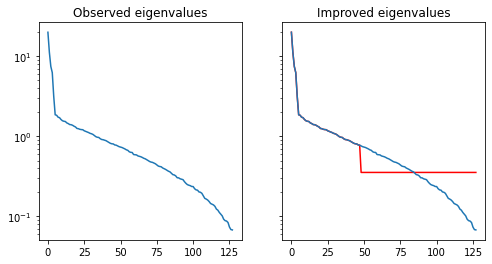

In [20]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax0.semilogy(obs_eigen_values)
ax1.semilogy(improved_eigen_values,'r')
ax1.semilogy(obs_eigen_values)
ax0.set_title('Observed eigenvalues')
ax1.set_title('Improved eigenvalues')
plt.show()

In [21]:
print(f'condition number of the IMPROVED covariance matrix is {improved_eigen_values[0]/improved_eigen_values[-1]:.2f}' )

condition number of the IMPROVED covariance matrix is 56.46


This simple trick improved the condition number with a factor 5-6.

We can now RECONSRUCT THE COVARIANCE MATRIX from the eigenvalues to get a denoised covariance matrix that will have a much better condition number.

In [22]:
improved_cor = eig_to_cor(improved_eigen_values, obs_eigen_vectors)

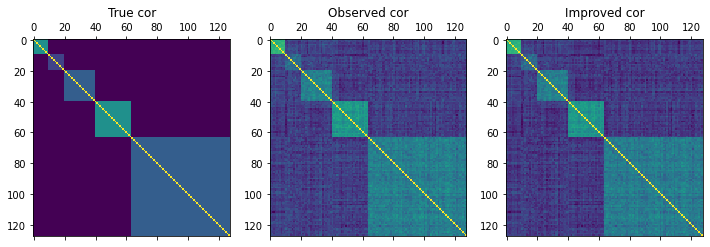

In [23]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(12,4))
ax0.matshow(true_cor)
ax1.matshow(observed_cor)
ax2.matshow(improved_cor)
ax0.set_title('True cor')
ax1.set_title('Observed cor')
ax2.set_title('Improved cor')
plt.show()

What's interesting to see is that the two correlation matrices on the right look very similar, BUT the right one is much better.

## How many of the smallest eigenvalues should we fix?


In the earlier example I've replaced the 80 smallest eigenvalues with their average but that was just an arbitrary choice. The more small eigenvalues we replace by their mean, the better the condition number will be. However, if we replace too many then we will start changing the large common factors that drive the "true asset correlations", and we want to leave those intact and not mess them up.

One approach is to try and estimate the number of noise- and signal-eigenvectors. A theoretical model for a mixed signal+noise covariance matrix is as follows:

* Create uncorrelated noisy time series with a certain noise level
* Calculate the covariation matrix
* Add a strong "true" signal to the covariation matrix
* Convert to correlation
* Look at the eigenvalues

This recipe gives an eigenvalue distrtibution with two distinct regions of eigenvalues: 
* the small eigenvalues come from the noise and have a Marcenko Pastur distribution. https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
* the large eigenvalues come from the true signal

Below you see the eigenvalue distribution (eigenvalues on the x-axis, density on the y-axis) for our observation covariance matrix. If has a large desity of small eigenvalues at the left, and then there is 5 eigenvalues {3,6,7,13,21} that are associated with a true signal (it's the 5 blocks along the diagonal of mutually correlated assets in the intial covarance matrix).

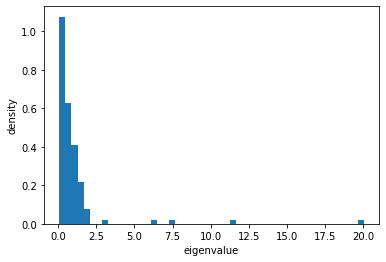

In [24]:
plt.hist(obs_eigen_values, density=True, bins=50)
plt.xlabel('eigenvalue')
plt.ylabel('density')
plt.show()

Here is another plot, but this time zoomed in on the left part.

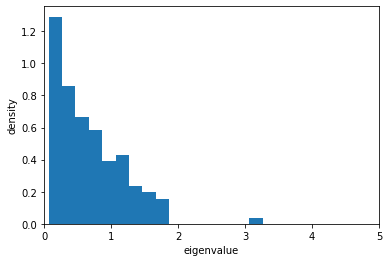

In [25]:
plt.hist(obs_eigen_values, density=True, bins=100)
plt.xlabel('eigenvalue')
plt.ylabel('density')
plt.xlim(0,5)
plt.show()

Next we plot various Marcenko Pastur distribution. The goal is to see if one of them fits the observed eigenvalue didstribution, and then use that to identify what eigenvalues are noise, and which ones are signal.

In [26]:
def marcenko_pastur_support(var, T, N):
    q = T / N
    return var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2


def marcenko_pastur_pdf(var, T, N, eigen_values):
    q = T / N
    e_min, e_max = marcenko_pastur_support(var, T, N)
    pdf = np.zeros_like(eigen_values)
    mask = np.logical_and(eigen_values > e_min, eigen_values < e_max)
    pdf[mask] = q / (2 * np.pi * var * eigen_values[mask]) * (
            (e_max - eigen_values[mask]) * (eigen_values[mask] - e_min)) ** .5
    return pdf

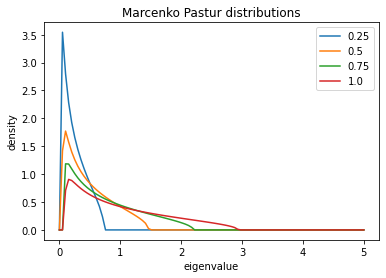

In [27]:
fig, ax = plt.subplots(1,1)
x = np.linspace(0,5,100)
for noise_level in [0.25,  0.5, 0.75, 1.0]:
    p = marcenko_pastur_pdf(noise_level, num_timesteps, num_assets, x)
    ax.plot(x,p, label=f'{noise_level}')
plt.xlabel('eigenvalue')
plt.ylabel('density')
plt.title('Marcenko Pastur distributions')
plt.legend()
plt.show()
    

Looking at the height and the x-range of the distribution, it looks like the green one with a noise variance of 0.75 is the best fit.

The code below finds the optimal fit using a maximum log likelihood search.

In [28]:
def find_mp_var(T, N, eigen_values):
    max_ll = -1E9
    max_var = 0
    for var in np.linspace(0.01, 4, 1000):
        pdf = marcenko_pastur_pdf(var, T, N, eigen_values)
        noise_mask = (pdf > 0.0)
        pdf[~noise_mask] = 1.0 / np.max(eigen_values)
        ll = np.sum(np.log(pdf))
        if ll > max_ll:
            max_ll = ll
            max_var = var
    return max_var

In [29]:
best_var = find_mp_var(num_timesteps, num_assets, obs_eigen_values)

print(f'Best fit has a noise variance of {best_var:.2f}')

Best fit has a noise variance of 0.66


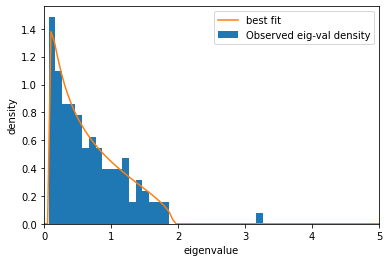

In [30]:
x = np.linspace(0, 5, 100)

p = marcenko_pastur_pdf(best_var, num_timesteps, num_assets, x)
plt.hist(obs_eigen_values, density=True, bins=200, label='Observed eig-val density')
plt.plot(x, p, label='best fit')
plt.xlabel('eigenvalue')
plt.ylabel('density')
plt.xlim(0, 5)
plt.legend()
plt.show()

We can now look at the largest eigenvalue where the Marcenko Pastur distribution is still positive. This is just below 2. All eigenvalues below that value are considered "noise" factors.

In [31]:
_, max_noise_eig_val = marcenko_pastur_support(best_var, num_timesteps, num_assets)

print(f'All eigenvalues below {max_noise_eig_val:.2f} are considerd noise components, we will replace those with their average.')

All eigenvalues below 1.93 are considerd noise components, we will replace those with their average.


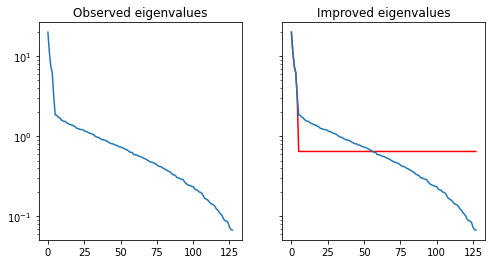

In [32]:
improved_eigen_values = obs_eigen_values.copy()

improved_eigen_values[improved_eigen_values<max_noise_eig_val] = np.mean(improved_eigen_values[improved_eigen_values<max_noise_eig_val])

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax0.semilogy(obs_eigen_values)
ax1.semilogy(improved_eigen_values,'r')
ax1.semilogy(obs_eigen_values)
ax0.set_title('Observed eigenvalues')
ax1.set_title('Improved eigenvalues')
plt.show()

In [33]:
improved_cor = eig_to_cor(improved_eigen_values, obs_eigen_vectors)
improved_cov = cor_to_cov(improved_cor, observed_std)

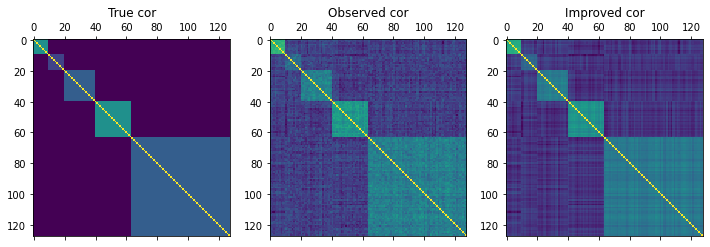

In [34]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(12,4))
ax0.matshow(true_cor)
ax1.matshow(observed_cor)
ax2.matshow(improved_cor)
ax0.set_title('True cor')
ax1.set_title('Observed cor')
ax2.set_title('Improved cor')
plt.show()

# Part 3: Does is really work for portfolio optimisation??

To check if it all works, we will use the two covariance matrices to construct a min-variance portfolio allocation, and then see how these allocations perform on NEW asset return data.

In [35]:
def min_var_alloc(cov):
    cov_inv = np.linalg.inv(cov)
    w = np.matmul(cov_inv, np.ones((cov.shape[0],1)))
    return w/np.sum(w)


Compute the min-var portfoloio weights based on the two different covariance matrices.

In [36]:
raw_weights = min_var_alloc(observed_cov)
clean_weights = min_var_alloc(improved_cov)


Simulate new asset returns based on the TRUE covariance, and compute the variance of the min-variance portfolios.

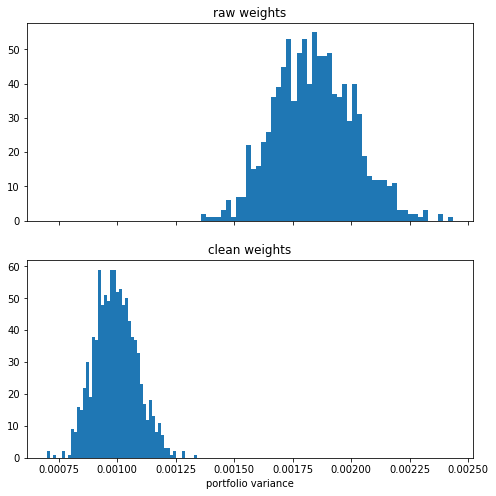

In [37]:
raw_weights = min_var_alloc(observed_cov)
clean_weights = min_var_alloc(improved_cov)

raw_vars = []
clean_vars = []
for _ in range(1000):
    new_observed_returns = np.random.multivariate_normal(mean=np.zeros(num_assets), cov=true_cov, size=num_timesteps)
    
    raw_portfolio_returns = np.matmul(new_observed_returns, raw_weights) 
    raw_vars.append(np.var(raw_portfolio_returns))

    clean_portfolio_returns = np.matmul(new_observed_returns, clean_weights) 
    clean_vars.append(np.var(clean_portfolio_returns))

    
    
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(8,8),sharex=True)
ax0.hist(raw_vars,bins=50)
ax1.hist(clean_vars,bins=50)
ax0.set_title('raw weights')
ax1.set_title('clean weights')
ax1.set_xlabel('portfolio variance')
plt.show()

Clearly, the clean covariance matrix gives a much better min-var allocation on new data!